In [1]:
import pandas
import numpy as np
from datetime import datetime, timedelta
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from StockPriceForModel import StockPriceForModel


## Getting stock data from StockPriceForModel
We can choose any ticker and the time period (e.g. 2,3,5 or 10 years) to train and predict data. The code will grasp data from today to the time period you choose.

In this code, we choose APPLE stock with time period = 10 years.

Each record in the price_features will contains the original stock trading data and the price label (label_price) which is the close price of the next day as the class to predict.

We also add numbers of technical indicators which captures all historical data and the historical stock movement's important information.

Here is the list of technical indicators we have added into our stock dataset:

middle = (close + high + low) / 3
SMA: simple moving average
EMA: exponential moving average
MSTD: moving standard deviation
MVAR: moving variance
RSV: raw stochastic value
RSI: relative strength index
KDJ: Stochastic oscillator
Bolling: including upper band and lower band.
MACD: moving average convergence divergence. Including signal and histogram. (see note)
CR:
WR: Williams Overbought/Oversold index
CCI: Commodity Channel Index
TR: true range
ATR: average true range
line cross check, cross up or cross down.
DMA: Different of Moving Average (10, 50)
DMI: Directional Moving Index, including
+DI: Positive Directional Indicator
-DI: Negative Directional Indicator
ADX: Average Directional Movement Index
ADXR: Smoothed Moving Average of ADX
TRIX: Triple Exponential Moving Average
VR: Volatility Volume Ratio


In [2]:
ticker = 'AAPL'
to_date = datetime.strftime(datetime.today() - timedelta(days=1), '%Y-%m-%d')
from_date = datetime.strftime(datetime.today() - timedelta(days=10*365), '%Y-%m-%d')
appl = StockPriceForModel(ticker, from_date, to_date, 2, 15)
dataframe = appl.price_features
dataframe = dataframe.dropna()

C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\stockstats.py:189: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  center=False, window=shifts).apply(np.count_nonzero)
C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will

## Plot the stock's close price
In this block, we plot the close price of the stock comparing with the simple movement average of 50, 200 days.
You can the trend for short term and long term price movement. 

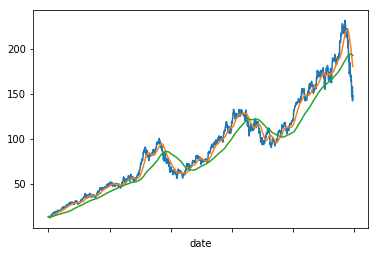

In [4]:
#print(dataframe.columns.get_values())
sp_close_series = dataframe.close
sp_close_series.plot()
sp_sma_series_50 = dataframe.close_50_sma  
sp_sma_series_50.plot()
sp_sma_series_200 = dataframe.close_200_sma  
sp_sma_series_200.plot()

## Model
We use a simple linear regression as the first model for our prediction.
We also use pipline to do some feature tasks:
+ Impute missing values using the mean
+ Transform features to quadratic
+ Fit a linear regression
The returned performances are quit good with R^2 in range of [0.5,1]

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer 
from sklearn import model_selection

model = make_pipeline(SimpleImputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

X = dataframe.loc[:, dataframe.columns != 'label_price']
y = dataframe.loc[:,'label_price']
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
scoring = 'neg_mean_absolute_error'
results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("MAE: ", results.mean(), results.std())
scoring = 'r2'
results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("R^2:", results.mean(), results.std())

MAE:  -4.161021704365648 6.312013088348383
R^2: -177.82094261059245 536.0203238206814


## Ensemble Method ##

We are going to try to combine a PolynomialRegression with a kNN model. 

__PloynomialRegression__ is a simple technique and quite easy to interpret. A possible issue with __PolynomialRegression__  is that, in our case, overfitting becomes a very distinct possibility.

__kNN__ is another model that would probably work for us. __kNN__ finds similarities between new data and old data based on independent variables.

First let's check how second degree __PolynomialRegression__ model perfoms. We are going to plot real data and predictions for last bunch of points.

Let's check how many rows we have in total in our dataframe.

In [6]:
len(dataframe.index)

2490

We are going to use 90% of data as train set and last 10% as test set.

In [7]:

X_train = X[:2241]
y_train = y[:2241]

X_valid = X[2241:]
y_valid = y[2241:]

#check if dwe have any NA's in the data - in theory we should not observe any NA's
print('Do we have any NA values for train data? ', X_train.isnull().values.any(), y_train.isnull().values.any())
print('Do we have any NA values for test data? ', X_valid.isnull().values.any(), y_valid.isnull().values.any())


Do we have any NA values for train data?  False False
Do we have any NA values for test data?  False False


In [8]:
import numpy as np

lin_regressor = LinearRegression()

# pass the order of your polynomial here  
poly = PolynomialFeatures(2)

# convert to be used further to linear regression
X_transform = poly.fit_transform(X_train)

# fit this to Linear Regressor
lin_regressor.fit(X_transform,y_train) 

X_transform_valid = poly.fit_transform(X_valid)

y_preds = lin_regressor.predict(X_transform_valid)

#make predictions and find the rmse
#preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(y_preds)),2)))
rms

4.186455140642972

C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


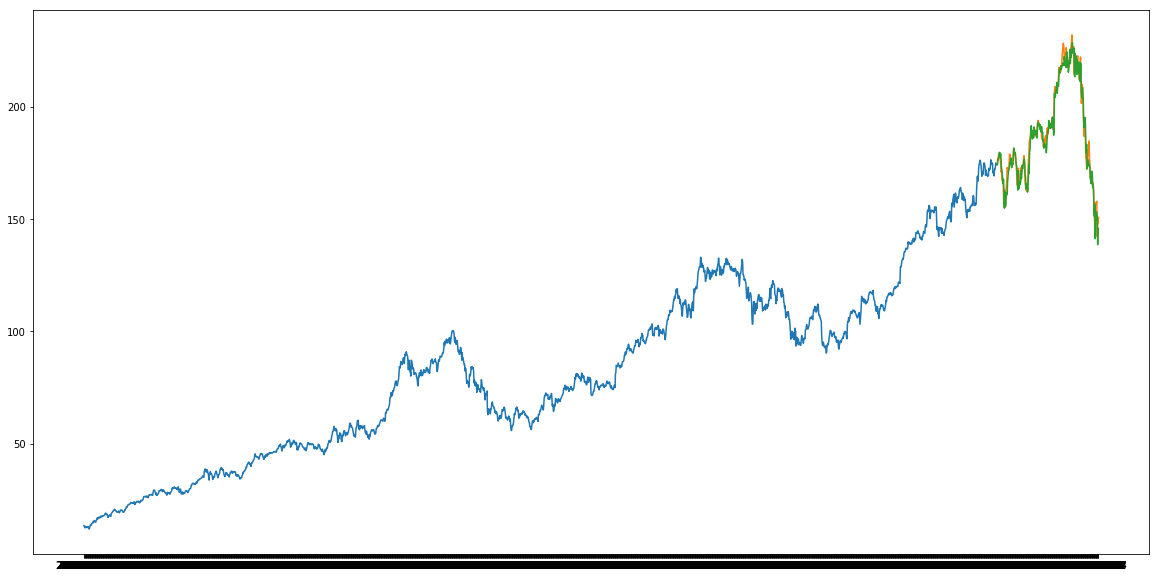

In [9]:
#plot
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

train = dataframe[:2241]
valid = dataframe[2241:]


valid['Predictions'] = 0
valid['Predictions'] = y_preds

valid.index = dataframe[2241:].index
train.index = dataframe[:2241].index

plt.plot(train['label_price'])
plt.plot(valid[['label_price', 'Predictions']])

Interesting plot. Did we run into overfitting? Let's try __kNN__ and check it's results.

## kNN ##

In [10]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler(feature_range=(0, 1))



#scaling data
#x_train_scaled = scaler.fit_transform(X_train)
#x_train_df = pd.DataFrame(x_train_scaled)
#x_valid_scaled = scaler.fit_transform(X_valid)
#x_valid_df = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(X_train,y_train)
preds = model.predict(X_valid)

C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Results ###

In [11]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

69.83103263980398

We notice above that the RMSE is really big for kNN compared with a linear regression. Try to plot the data and look at results.

C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


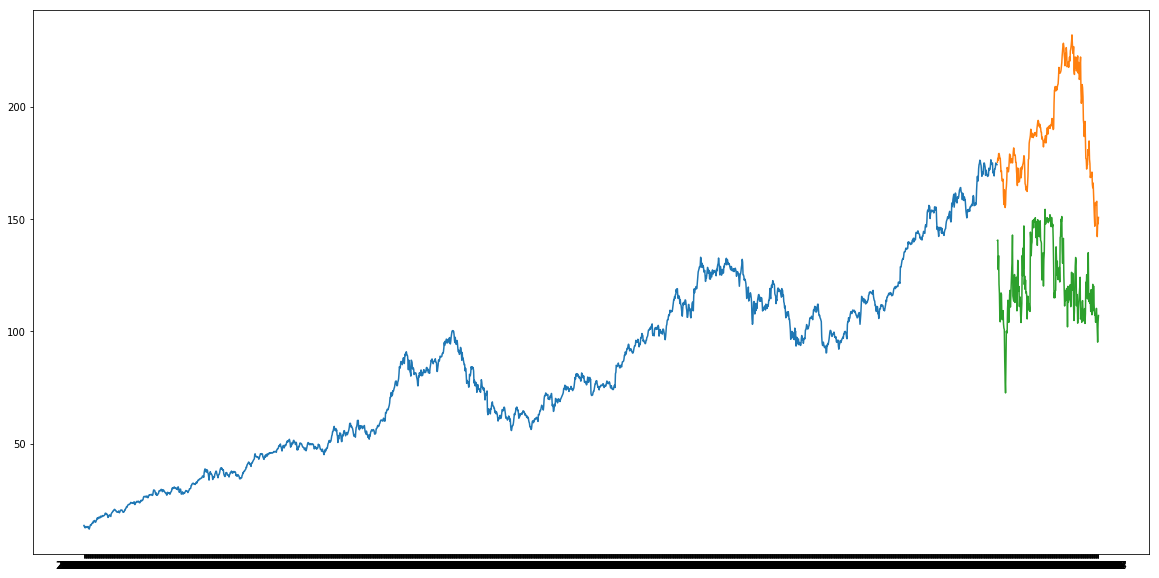

In [14]:
#plot
train = dataframe[:2241]
valid = dataframe[2241:]

valid['Predictions'] = 0
valid['Predictions'] = preds
valid.index = dataframe[2241:].index
train.index = dataframe[:2241].index
plt.plot(train['label_price'])
plt.plot(valid[['label_price', 'Predictions']])

As we can see above __kNN__ follows the price changes but it has a __high bias__.

In [ ]:
"""

from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np

lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
svr_rbf = SVR(kernel='rbf')

stregr = StackingRegressor(regressors=[svr_lin, lr, ridge], 
                           meta_regressor=svr_rbf)

X_train = X[:2241]
y_train = y[:2241]

X_valid = X[2241:]
y_valid = y[2241:]

stregr.fit(X_train, y_train)
y_predicted = stregr.predict(X_valid)

print("Mean Squared Error: %.4f"
      % np.mean((stregr.predict(X_valid) - y_valid) ** 2))
print('Variance Score: %.4f' % stregr.score(X_valid, y_valid))

with plt.style.context(('seaborn-whitegrid')):
    plt.scatter(X, y, c='lightgray')
    plt.plot(X, stregr.predict(X), c='darkgreen', lw=2)

plt.show()
"""


C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


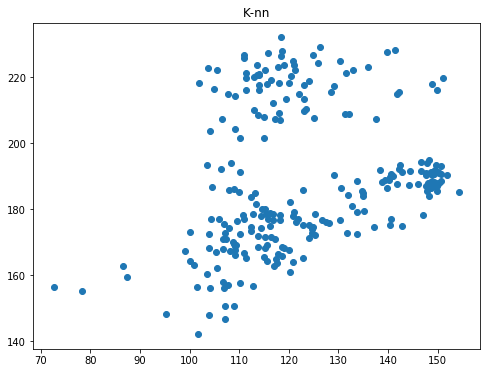

RMSE for  K-nn  is  4876.37311954137


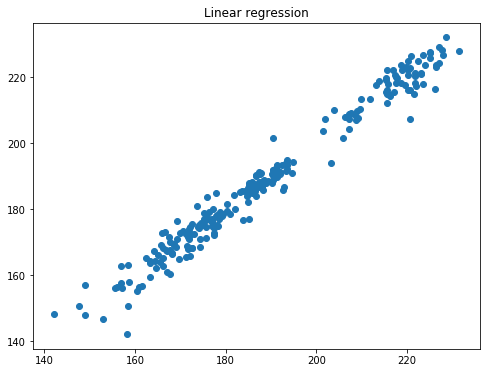

RMSE for  Linear regression  is  12.16264693215614


C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


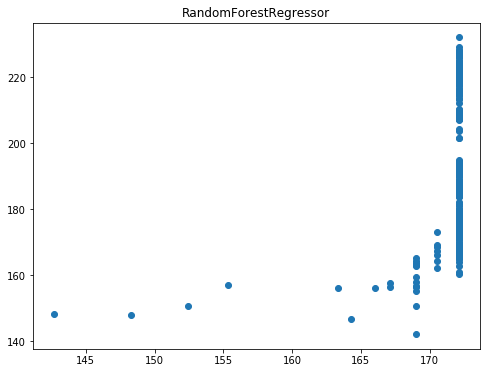

RMSE for  RandomForestRegressor  is  709.3336763549689


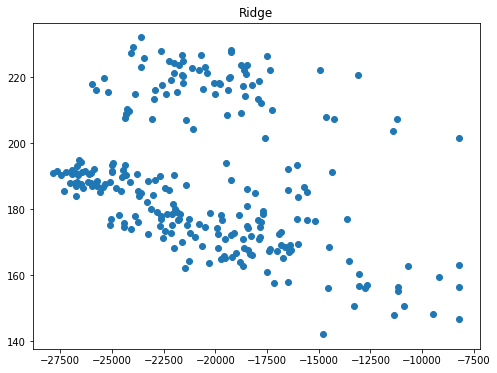

RMSE for  Ridge  is  446114272.1965146


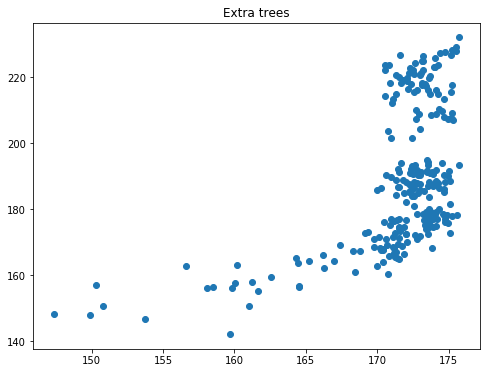

RMSE for  Extra trees  is  665.1428643473273


In [15]:
#this has been brought to you courtesy of: 
# https://www.kaggle.com/reenanitr01/multi-output-regression-techniques

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor

X_train = X[:2241]
y_train = y[:2241]

X_test = X[2241:]
y_test = y[2241:]

params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn1 = neighbors.KNeighborsRegressor()
model1 = GridSearchCV(knn1, params, cv=5)

ESTIMATORS = {
    "K-nn": model1,                          # Accept default parameters
    "Linear regression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(max_depth=4, random_state=2),
    "Ridge": RidgeCV(),
    "Extra trees": ExtraTreesRegressor(n_estimators=10,
                                       random_state=0)
}

# 9.1 Create an empty dictionary to collect prediction values
y_test_predict = dict()
y_mse = dict()

for name, estimator in ESTIMATORS.items():     
    estimator.fit(X_train, y_train)                    # fit() with instantiated object
    y_test_predict[name] = estimator.predict(X_test)   # Make predictions and save it in dict under key: name
    y_mse[name] = mean_squared_error(y_test, estimator.predict(X_test))
    
    #show_image(test,X_test,y_test_predict,name,n_faces,y_mse)
    
    plt.figure(figsize=(8,6))
    plt.scatter(y_test_predict[name],y_test,cmap='plasma')
    plt.title(name)
    plt.show()
    print('RMSE for ',name,' is ',y_mse[name])


In [85]:
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import model_selection


class RidgeTransformer(Ridge, TransformerMixin):

    def transform(self, X, *_):
        return self.predict(X)


class RandomForestTransformer(RandomForestRegressor, TransformerMixin):

    def transform(self, X, *_):
        return self.predict(X)


class KNeighborsTransformer(KNeighborsRegressor, TransformerMixin):

    def transform(self, X, *_):
        return self.predict(X)
    

def build_model():
    ridge_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly_feats', PolynomialFeatures(2)),
        ('ridge', RidgeTransformer())
    ])

    pred_union = FeatureUnion(
        transformer_list=[
            ('ridge', ridge_transformer),
            ('rand_forest', RandomForestTransformer()),
            ('knn', KNeighborsTransformer())
        ],
        n_jobs=2
    )

    model = Pipeline(steps=[
        ('pred_union', pred_union),
        ('lin_regr', LinearRegression())
    ])

    return model

In [83]:

print('Build and fit a model..')

print(len(dataframe.index))

model = build_model()

X1 = dataframe.loc[:, dataframe.columns != 'label_price']
y1 = dataframe.loc[:,'label_price']

#XX1 = pd.DataFrame(X1)
#yy1 = pd.DataFrame(y1)

#print(yy1.head())

#print(list(y1))

#use first 80% smaples for train and last 20% sample for test
#train = dataframe[:1992]
#test = dataframe[1992:]

#X_train1 = train.loc[:, dataframe.columns != 'label_price']
#y_train1 = train.loc[:,'label_price']

#y_train1.reshape(-1, 1)


X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)


y_train2 = y_train1.values
y_train3 = y_train2.reshape((y_train2.shape[0],1))

#print(y_train3)

print(y_train3.shape)
print(X_train3.shape)

#print(y_train2.shape)
#print(y_train3.shape)

#print(X_train1[:2])
#print(y_train2[:2])

#y_train1.values.reshape(-1, 1)
#print(y_train1.head())

#print(X_train1.values)

#y_train1.reshape(-1, 1)
#print(X_train1.shape, y_train1.shape)
#print(X_test1.shape, y_test1.shape)

#X_train_array = X_train1.as_matrix()
#y_train_array = y_train1.as_matrix()

#print(y_train_array)

#y_train_array.reshape(-1, 1)
#X_train_array.reshape(-1, 1)


model.fit(X1, y1)
#score = model.score(X_valid, y_valid)

#print('Done. Score:', score)

Build and fit a model..
2490
date
2017-09-06     161.26
2013-09-04    70.7529
2014-09-30      99.18
2010-06-21    39.1214
2010-07-30    37.4071
2010-11-30       45.2
2012-09-04    95.7471
2018-07-03      185.4
2018-05-10     188.59
2014-04-16    74.9914
2016-07-18      99.87
2011-10-10    57.1843
2013-11-18    74.2214
2016-09-14     115.57
2013-09-12    66.4143
2018-09-25     220.42
2015-09-14     116.28
2013-11-27    79.4386
2016-09-20     113.55
2012-02-07    68.0971
2016-04-20     105.97
2010-09-30      40.36
2010-06-04    35.8486
2009-09-21    26.3543
2013-10-11    70.8629
2009-09-02    23.7929
2013-08-16    72.5343
2010-08-05    37.1557
2018-04-12     174.73
2012-04-13    82.8757
               ...   
2018-06-29     187.18
2017-09-26     154.23
2015-07-16     129.62
2014-10-24     105.11
2013-10-16    72.0714
2017-03-17     141.46
2015-11-17     117.29
2010-04-28    38.3771
2013-11-19    73.5714
2014-02-27    75.1771
2016-06-28       94.4
2014-07-18      93.94
2012-03-01    77.882

ValueError: Expected 2D array, got 1D array instead:
array=[ 13.4814284   12.94872819  13.29399814 ... 116.62599945 122.87199707
 117.96799774].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


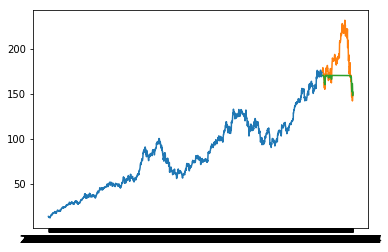

In [89]:
# Using Gradient Boosting Regressor
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

X_train = X[:2241]
y_train = y[:2241]

X_valid = X[2241:]
y_valid = y[2241:]

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                 max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)

preds = est.predict(X_valid)
mean_squared_error(y_valid, est.predict(X_valid))    

train = dataframe[:2241]
valid = dataframe[2241:]

valid['Predictions'] = 0
valid['Predictions'] = preds
valid.index = dataframe[2241:].index
train.index = dataframe[:2241].index
plt.plot(train['label_price'])
plt.plot(valid[['label_price', 'Predictions']])

688.9732831847126


C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


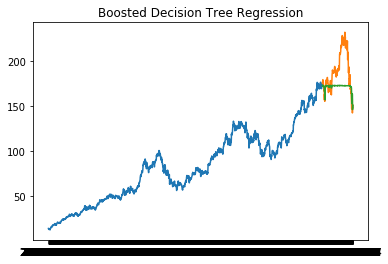

In [96]:
# Using AdaBoostRegression with DecisionTreeRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create the dataset
rng = np.random.RandomState(1)

X_train = X[:2241]
y_train = y[:2241]

X_valid = X[2241:]
y_valid = y[2241:]

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_valid)
y_2 = regr_2.predict(X_valid)
print(mean_squared_error(y_valid,y_2))    

# Plot AdaBoostRegressor regression
valid['Predictions'] = 0
valid['Predictions'] = y_2
valid.index = dataframe[2241:].index
train.index = dataframe[:2241].index
plt.title("Boosted Decision Tree Regression")
plt.plot(train['label_price'])
plt.plot(valid[['label_price', 'Predictions']])
